In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import ndimage

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
np.random.seed(42)
torch.manual_seed(42)

CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

In [3]:
with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()

In [4]:
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

with h5py.File(CUBE_PATH, "r") as cube:
    spectra_zoom0 = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:][mask]
    images_zoom0 = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:][mask]

metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]

In [5]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    return "GALAXY" if "GALAXY" in val else "OTHER"

labels_simplified = pd.Series(labels).apply(simplify_targettype).values
galaxy_mask = labels_simplified == "GALAXY"
valid_indices = ~np.isnan(spectra_zoom0).any(axis=1)
final_mask = galaxy_mask & valid_indices
print("Number of objects after filtering:", final_mask.sum())

Number of objects after filtering: 10126


In [6]:
Y_all = valid_sfrs.loc[metadata_indices_filtered, "AVG"].values
Y = Y_all[final_mask]

In [7]:
filters = ["u", "g", "r", "i", "z"]

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
    
    images_zoom = images_zoom[final_mask]
    spectra_zoom = spectra_zoom[final_mask]
    
    if zoom == 0:
        reference_spectrum = spectra_zoom.copy()
        reference_images = images_zoom.copy()
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

In [8]:
def detect_and_visualize_multiple_objects(all_images, thresholds, max_objects=20, thumbnail_size=3, crop_sizes=None):
    all_images_trimmed = []
    for i, img_array in enumerate(all_images):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size)
        
        start = (original_size - target_size) // 2
        end = start + target_size
        
        trimmed = img_array[..., start:end, start:end]
        all_images_trimmed.append(trimmed)
    
    multi_obj_indices = []
    for idx in range(all_images_trimmed[0].shape[0]):
        image = all_images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds[0]
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)

    if len(multi_obj_indices) > max_objects:
        print(f"Found {len(multi_obj_indices)} objects. Showing first {max_objects}")
        multi_obj_indices = multi_obj_indices[:max_objects]

    if not multi_obj_indices:
        print("No multi-object sources found")
        return all_images_trimmed
    
    num_rows = len(multi_obj_indices)
    fig, axes = plt.subplots(
        num_rows,
        5,
        figsize=(15, thumbnail_size * num_rows),
        dpi=100
    )
    
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for row, obj_idx in enumerate(multi_obj_indices):
        for col in range(5):
            ax = axes[row, col]
            img_data = all_images_trimmed[0][obj_idx, col, :, :]
            ax.imshow(img_data, vmin=-1, vmax=1)
            ax.set_title(f"Filter {filters[col]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    return all_images_trimmed

In [9]:
THRESHOLDS_4 = {
    0: 0.90,
    1: 0.93,
    2: 0.97,
    3: 0.99
}

CROP_SIZES_4 = {
    0: 32, 
    1: 16, 
    2: 8, 
    3: 4   
}

In [10]:
cropped_images = []
for zoom in range(4):
    img_array = all_images[zoom]
    original_size = img_array.shape[-1]
    target_size = CROP_SIZES_4.get(zoom, original_size)
    start = (original_size - target_size) // 2
    end = start + target_size
    cropped = img_array[..., start:end, start:end]
    cropped_images.append(cropped)

In [11]:
# Dictionary to store results for each spectra zoom level
results_fusion = {}

# Use the fixed image modality from cropped_images[0]
X_img = cropped_images[0]
n_samples = X_img.shape[0]
X_img = X_img.reshape(n_samples, -1)  # flatten images

In [12]:
X_img_train, X_img_temp, X_spec_train, X_spec_temp, y_train, y_temp = train_test_split(
    X_img, all_spectra[:][0], Y, test_size=0.4, random_state=42)

X_img_val, X_img_test, X_spec_val, X_spec_test, y_val, y_test = train_test_split(
    X_img_temp, X_spec_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
class EarlyFusionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Intermediate Fusion Model
class IntermediateFusionNet(nn.Module):
    def __init__(self, img_dim, spec_dim):
        super().__init__()
        self.img_branch = nn.Sequential(
            nn.Linear(img_dim, 64), nn.ReLU(), nn.Dropout(0.3)
        )
        self.spec_branch = nn.Sequential(
            nn.Linear(spec_dim, 32), nn.ReLU(), nn.Dropout(0.3)
        )
        self.fusion = nn.Sequential(
            nn.Linear(96, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, img, spec):
        img_feat = self.img_branch(img)
        spec_feat = self.spec_branch(spec)
        combined = torch.cat([img_feat, spec_feat], dim=1)
        return self.fusion(combined)

# Late Fusion Model
class LateFusionNet(nn.Module):
    def __init__(self, img_dim, spec_dim):
        super().__init__()
        self.img_net = nn.Sequential(
            nn.Linear(img_dim, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        self.spec_net = nn.Sequential(
            nn.Linear(spec_dim, 32), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, img, spec):
        img_pred = self.img_net(img)
        spec_pred = self.spec_net(spec)
        return (img_pred + spec_pred) / 2

In [14]:
# Parameters
img_pca_components = 100
spec_pca_components = {0: 50, 1: 40, 2: 30, 3: 20}  # Different components for each zoom
batch_size = 64
epochs = 100
patience = 10
learning_rate = 0.0005

# Results storage
results_fusion = {}
train_loss_history = {}
val_loss_history = {}

fusion_methods = {"Early Fusion": EarlyFusionNet, "Intermediate Fusion": IntermediateFusionNet, "Late Fusion": LateFusionNet}

Processing Zoom Level 0
Training Early Fusion for Zoom Level 0
Early stopping at epoch 49 for Early Fusion - Zoom 0


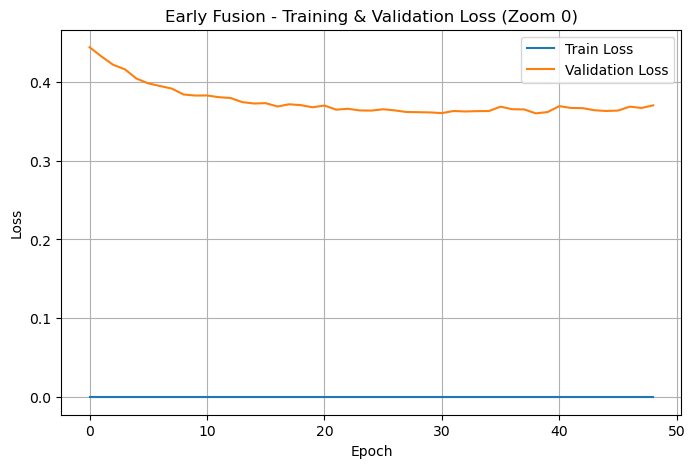

Early Fusion - Zoom 0 - MSE: 0.3859, R2: 0.2297
Training Intermediate Fusion for Zoom Level 0
Early stopping at epoch 72 for Intermediate Fusion - Zoom 0


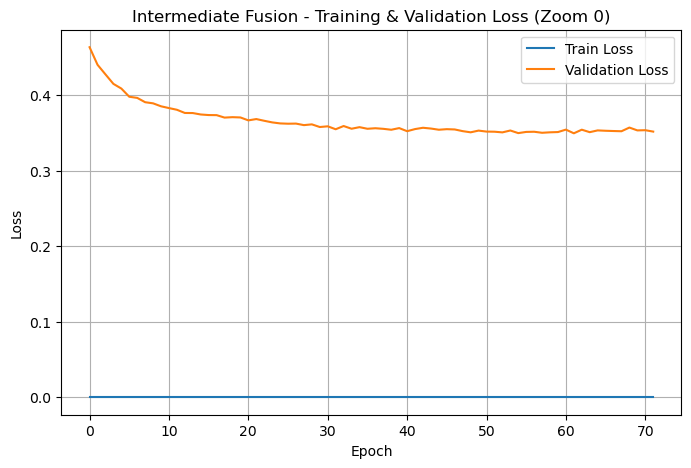

Intermediate Fusion - Zoom 0 - MSE: 0.3751, R2: 0.2513
Training Late Fusion for Zoom Level 0
Early stopping at epoch 69 for Late Fusion - Zoom 0


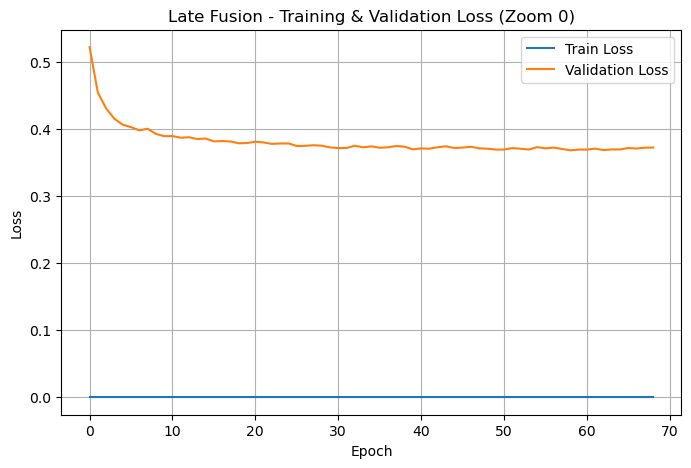

Late Fusion - Zoom 0 - MSE: 0.3843, R2: 0.2329
Processing Zoom Level 1
Training Early Fusion for Zoom Level 1
Early stopping at epoch 44 for Early Fusion - Zoom 1


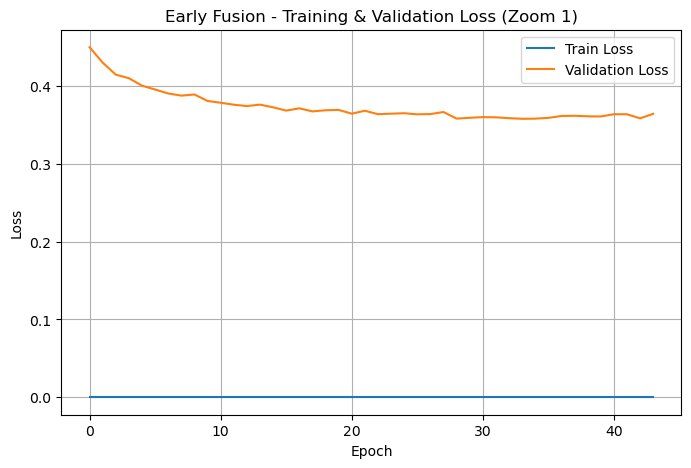

Early Fusion - Zoom 1 - MSE: 0.3757, R2: 0.2502
Training Intermediate Fusion for Zoom Level 1
Early stopping at epoch 74 for Intermediate Fusion - Zoom 1


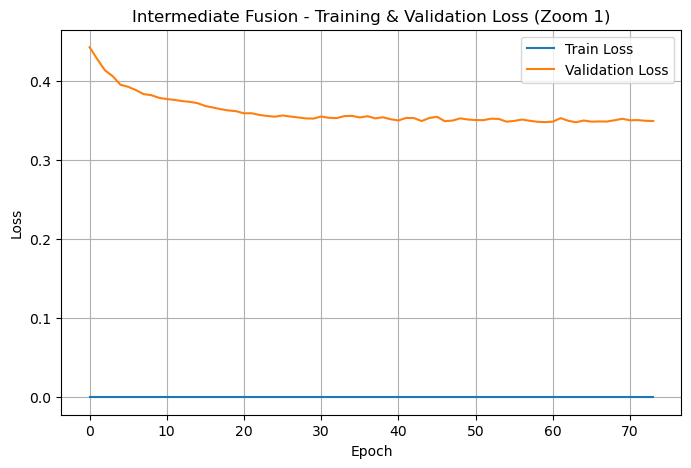

Intermediate Fusion - Zoom 1 - MSE: 0.3684, R2: 0.2646
Training Late Fusion for Zoom Level 1
Early stopping at epoch 42 for Late Fusion - Zoom 1


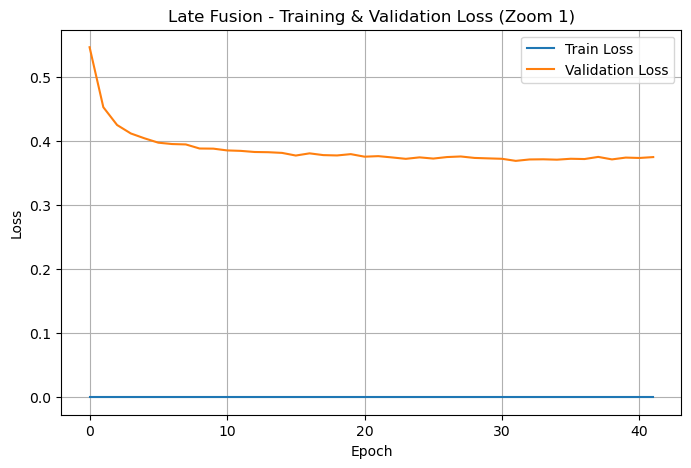

Late Fusion - Zoom 1 - MSE: 0.3869, R2: 0.2278
Processing Zoom Level 2
Training Early Fusion for Zoom Level 2
Early stopping at epoch 41 for Early Fusion - Zoom 2


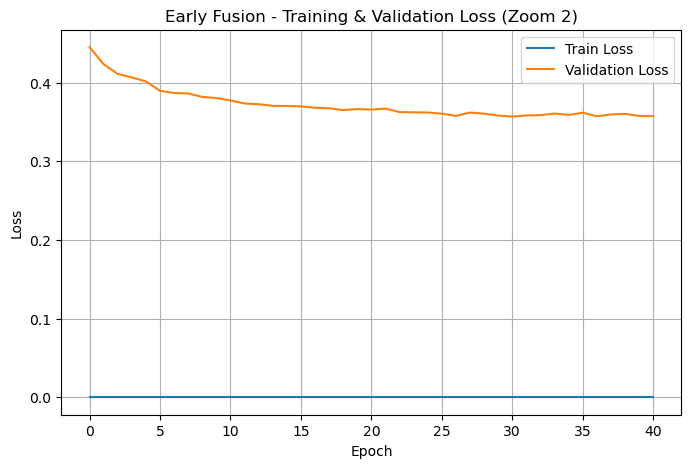

Early Fusion - Zoom 2 - MSE: 0.3735, R2: 0.2546
Training Intermediate Fusion for Zoom Level 2
Early stopping at epoch 66 for Intermediate Fusion - Zoom 2


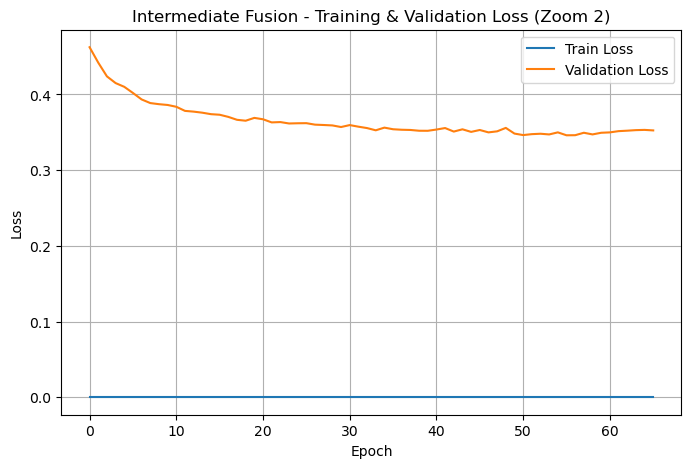

Intermediate Fusion - Zoom 2 - MSE: 0.3737, R2: 0.2541
Training Late Fusion for Zoom Level 2
Early stopping at epoch 65 for Late Fusion - Zoom 2


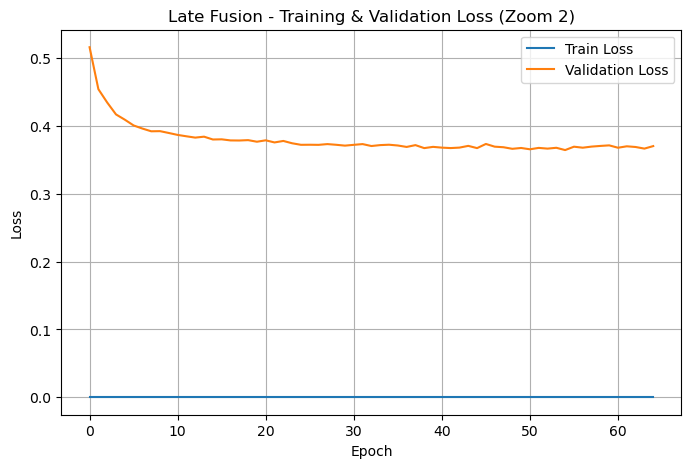

Late Fusion - Zoom 2 - MSE: 0.3862, R2: 0.2292
Processing Zoom Level 3
Training Early Fusion for Zoom Level 3
Early stopping at epoch 39 for Early Fusion - Zoom 3


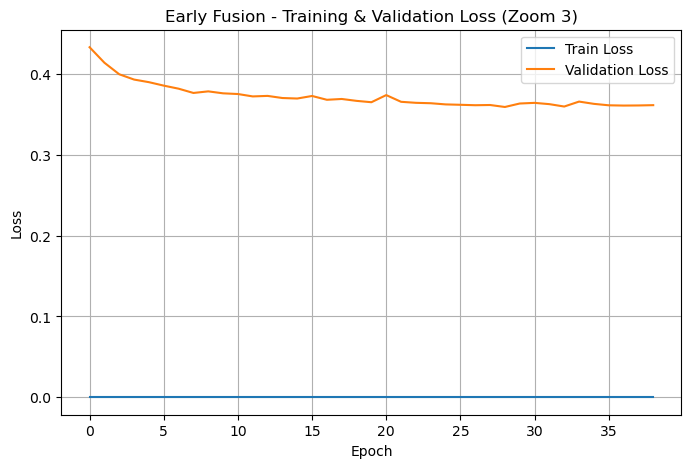

Early Fusion - Zoom 3 - MSE: 0.3778, R2: 0.2460
Training Intermediate Fusion for Zoom Level 3
Early stopping at epoch 87 for Intermediate Fusion - Zoom 3


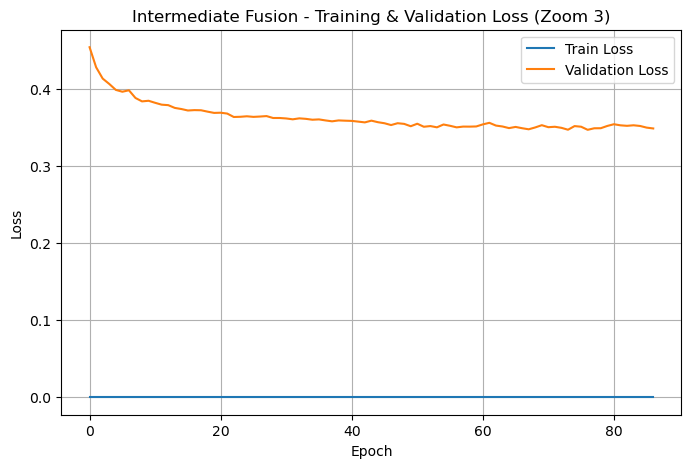

Intermediate Fusion - Zoom 3 - MSE: 0.3574, R2: 0.2866
Training Late Fusion for Zoom Level 3
Early stopping at epoch 68 for Late Fusion - Zoom 3


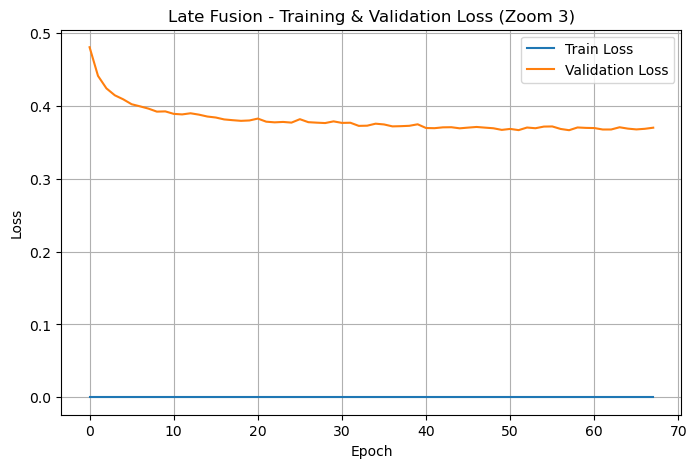

Late Fusion - Zoom 3 - MSE: 0.3848, R2: 0.2319


In [15]:
for zoom_level in range(4):
    print(f'Processing Zoom Level {zoom_level}')
    
    # Data preparation
    X_img_current = cropped_images[0].reshape(len(cropped_images[0]), -1)
    X_spec_current = all_spectra[:][zoom_level]
    
    X_img_train, X_img_temp, X_spec_train, X_spec_temp, y_train, y_temp = train_test_split(
        X_img_current, X_spec_current, Y, test_size=0.4, random_state=42)

    X_img_val, X_img_test, X_spec_val, X_spec_test, y_val, y_test = train_test_split(
        X_img_temp, X_spec_temp, y_temp, test_size=0.5, random_state=42)

    # Handle missing values with imputation
    imputer_spec = SimpleImputer(strategy="mean")
    imputer_img = SimpleImputer(strategy="mean")
    
    X_spec_train = imputer_spec.fit_transform(X_spec_train)
    X_spec_val = imputer_spec.transform(X_spec_val)
    X_spec_test = imputer_spec.transform(X_spec_test)

    X_img_train = imputer_img.fit_transform(X_img_train)
    X_img_val = imputer_img.transform(X_img_val)
    X_img_test = imputer_img.transform(X_img_test)

    # Scaling
    scaler_img = StandardScaler().fit(X_img_train)
    scaler_spec = StandardScaler().fit(X_spec_train)

    # PCA
    pca_img = PCA(n_components=img_pca_components).fit(scaler_img.transform(X_img_train))
    pca_spec = PCA(n_components=spec_pca_components[zoom_level]).fit(scaler_spec.transform(X_spec_train))
    
    # Transform data
    def transform_data(X_img, X_spec):
        return pca_img.transform(scaler_img.transform(X_img)), pca_spec.transform(scaler_spec.transform(X_spec))

    X_img_train_pca, X_spec_train_pca = transform_data(X_img_train, X_spec_train)
    X_img_val_pca, X_spec_val_pca = transform_data(X_img_val, X_spec_val)
    X_img_test_pca, X_spec_test_pca = transform_data(X_img_test, X_spec_test)

    train_loader = DataLoader(TensorDataset(torch.tensor(X_img_train_pca, dtype=torch.float32), 
                                            torch.tensor(X_spec_train_pca, dtype=torch.float32),
                                            torch.tensor(y_train)), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_img_val_pca, dtype=torch.float32), 
                                          torch.tensor(X_spec_val_pca, dtype=torch.float32),
                                          torch.tensor(y_val)), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_img_test_pca, dtype=torch.float32), 
                                           torch.tensor(X_spec_test_pca, dtype=torch.float32),
                                           torch.tensor(y_test)), batch_size=batch_size)

    for fusion_name, fusion_class in fusion_methods.items():
        print(f"Training {fusion_name} for Zoom Level {zoom_level}")

        if fusion_name == "Early Fusion":
            model = fusion_class(img_pca_components + spec_pca_components[zoom_level])
        elif fusion_name == "Intermediate Fusion":
            model = fusion_class(img_pca_components, spec_pca_components[zoom_level])  
        else:  # Late Fusion
            model = fusion_class(img_pca_components, spec_pca_components[zoom_level]) 

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        best_val_loss, patience_counter = np.inf, 0
        best_model_weights = None  
        
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for img, spec, y in train_loader:
                optimizer.zero_grad()
                
                if isinstance(model, EarlyFusionNet):
                    inputs = torch.cat([img, spec], dim=1)
                    pred = model(inputs).squeeze()
                else:
                    pred = model(img, spec).squeeze()
                
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            train_losses.append(train_loss / len(train_loader))

            model.eval()
            val_loss = np.mean([
                criterion(
                    model(torch.cat([img, spec], dim=1)).squeeze() if isinstance(model, EarlyFusionNet) else model(img, spec).squeeze(),
                    y
                ).item()
                for img, spec, y in val_loader
            ])
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_weights = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} for {fusion_name} - Zoom {zoom_level}")
                    break
        
        if best_model_weights is not None:
            model.load_state_dict(best_model_weights)
        
        # Loss visualization
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{fusion_name} - Training & Validation Loss (Zoom {zoom_level})')
        plt.legend()
        plt.grid()
        plt.show()

        # Evaluate and store results
        model.eval()
        preds = []
        with torch.no_grad():
            for img, spec, _ in test_loader:
                if isinstance(model, EarlyFusionNet):
                    inputs = torch.cat([img, spec], dim=1)  # Объединяем img и spec
                    pred = model(inputs).squeeze()
                else:
                    pred = model(img, spec).squeeze()
                
                preds.extend(pred.numpy())

        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        results_fusion[(zoom_level, fusion_name)] = {'MSE': mse, 'R2': r2}
        print(f"{fusion_name} - Zoom {zoom_level} - MSE: {mse:.4f}, R2: {r2:.4f}")


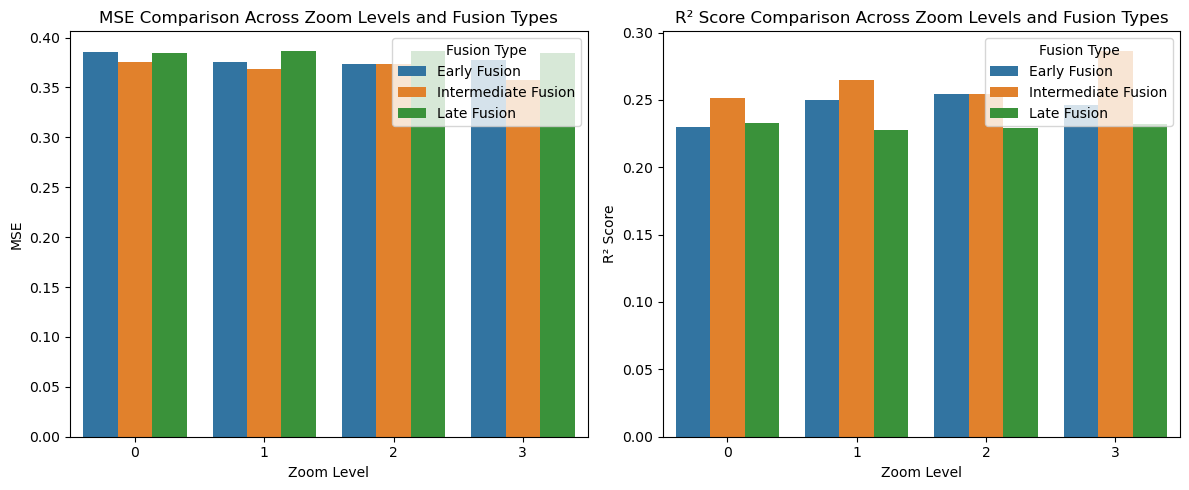

In [17]:
mse_results = []
r2_results = []

for (zoom_level, fusion_name), metrics in results_fusion.items():
    mse_results.append([zoom_level, fusion_name, metrics['MSE']])
    r2_results.append([zoom_level, fusion_name, metrics['R2']])

mse_results = np.array(mse_results, dtype=object)
r2_results = np.array(r2_results, dtype=object)

plt.figure(figsize=(12, 5))

# MSE Comparison
plt.subplot(1, 2, 1)
sns.barplot(x=mse_results[:, 0], y=mse_results[:, 2].astype(float), hue=mse_results[:, 1])
plt.xlabel("Zoom Level")
plt.ylabel("MSE")
plt.title("MSE Comparison Across Zoom Levels and Fusion Types")
plt.legend(title="Fusion Type")

# R2 Score Comparison
plt.subplot(1, 2, 2)
sns.barplot(x=r2_results[:, 0], y=r2_results[:, 2].astype(float), hue=r2_results[:, 1])
plt.xlabel("Zoom Level")
plt.ylabel("R² Score")
plt.title("R² Score Comparison Across Zoom Levels and Fusion Types")
plt.legend(title="Fusion Type")

plt.tight_layout()
plt.show()
